In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# need to install the Prophet package ahead
# try: $ pip install fbprophet
from fbprophet import Prophet

### Loading data

In [3]:
df = pd.read_csv("NEE_DATA.csv")  # use df contains missing values to run again

In [4]:
df.head(2)

,DATETIME,DACONG,DAENERGY,DALMP,DALOSS,DARTCONG,RTENERGY,RTLMP,RTLOSS,CDD,...,WSI_TRADER_TEMP,HOURENDING,MARKETDAY,PEAKTYPE,MONTH,YEAR,DALOAD,RTLOAD,SEASON,LOGDALMP
0,2017-01-01 01:00:00,0.0,34.86,34.84,-0.02,0.0,36.53,36.48,-0.05,0.0,...,38.8,1,2017-01-01 00:00:00,0,1,2017,2730.6,2842.3,4,3.550766
1,2017-01-01 02:00:00,0.0,33.72,33.80,0.08,0.0,37.02,37.01,-0.01,0.0,...,39.0,2,2017-01-01 00:00:00,0,1,2017,2583.5,2707.0,4,3.520461


In [5]:
df[df['DATETIME'] == '2019-06-01 00:00:00'].index

Int64Index([21142], dtype='int64')

In [6]:
train = df.loc[0:21142,['DATETIME','LOGDALMP','PEAKTYPE','MONTH','SEASON','HOURENDING',\
                       'NWS7FC_DPT_LATEST','NWS7FC_TMP_ORIG','WIND_NORM','NWS7FC_TMP_LATEST',\
                        'DEWPOINT_NORM_95','NWS7FC_P12_PRIMARY',\
                         'WETBULB_NORM_05','NWS7FC_Q12_LATEST']]
train.rename(columns={"DATETIME":"ds","LOGDALMP":"y"},inplace=True)

In [34]:
test = df.loc[21142:,['DATETIME','LOGDALMP','DALMP','PEAKTYPE','MONTH','SEASON','HOURENDING',\
                       'NWS7FC_DPT_LATEST','NWS7FC_TMP_ORIG','WIND_NORM','NWS7FC_TMP_LATEST',\
                        'DEWPOINT_NORM_95','NWS7FC_P12_PRIMARY',\
                         'WETBULB_NORM_05','NWS7FC_Q12_LATEST']]
test.rename(columns={"DATETIME":"ds","LOGDALMP":"y"},inplace=True)

In [8]:
# drop outliers for train
import statistics
from statistics import median
import astropy.stats 
from astropy.stats import median_absolute_deviation
med_dp = median(train['y'])
mad_dp = median_absolute_deviation(train['y'])
uprbound = med_dp+3*mad_dp  # calculate outlier cut-off
lwrbound = med_dp-3*mad_dp

In [9]:
train = train[(lwrbound<=train['y'].values) & (train['y'].values<=uprbound) ]

In [10]:
train.head(2)

,ds,y,PEAKTYPE,MONTH,SEASON,HOURENDING,NWS7FC_DPT_LATEST,NWS7FC_TMP_ORIG,WIND_NORM,NWS7FC_TMP_LATEST,DEWPOINT_NORM_95,NWS7FC_P12_PRIMARY,WETBULB_NORM_05,NWS7FC_Q12_LATEST
0,2017-01-01 01:00:00,3.550766,0,1,4,1,24,32.6,5.4,33.0,43.7,10,10.7,0
1,2017-01-01 02:00:00,3.520461,0,1,4,2,24,32.4,5.3,33.0,42.7,10,10.2,0


In [11]:
test.head(2)

,ds,y,PEAKTYPE,MONTH,SEASON,HOURENDING,NWS7FC_DPT_LATEST,NWS7FC_TMP_ORIG,WIND_NORM,NWS7FC_TMP_LATEST,DEWPOINT_NORM_95,NWS7FC_P12_PRIMARY,WETBULB_NORM_05,NWS7FC_Q12_LATEST
21142,2019-06-01 00:00:00,3.023347,0,6,1,24,53,66.8,4.5,67.2,67.1,1,46.5,0
21143,2019-06-01 01:00:00,2.896464,0,6,2,1,53,64.9,4.2,65.2,66.7,1,45.8,0


### Fitting prophet

In [12]:
m = Prophet(daily_seasonality=False,yearly_seasonality=3,weekly_seasonality=1)

m.add_seasonality(name='quarterly',period=91,fourier_order=3,prior_scale=2.5)

m.add_seasonality(name='daily',period=1,fourier_order=3, prior_scale=5)

m.add_regressor('NWS7FC_DPT_LATEST',prior_scale=5.5,standardize=True)

m.add_regressor('WIND_NORM',prior_scale=4,standardize=False)

m.add_regressor('NWS7FC_TMP_LATEST',prior_scale=3,standardize=True)

m.add_regressor('NWS7FC_TMP_ORIG',prior_scale=2.5,standardize=True)

m.add_regressor('DEWPOINT_NORM_95',prior_scale=2,standardize=False)

m.add_regressor('NWS7FC_P12_PRIMARY',prior_scale=2,standardize=True)

m.add_regressor('WETBULB_NORM_05',prior_scale=2,standardize=False)

m.add_regressor('NWS7FC_Q12_LATEST',prior_scale=2,standardize=True)

m.add_regressor('PEAKTYPE',prior_scale=5,standardize= False)

m.add_regressor('MONTH',prior_scale=3,standardize=False)

m.add_regressor('SEASON',prior_scale=3,standardize=False)

m.add_regressor('HOURENDING',prior_scale=5,standardize=False)

In [13]:
train.columns

Index(['ds', 'y', 'PEAKTYPE', 'MONTH', 'SEASON', 'HOURENDING',
       'NWS7FC_DPT_LATEST', 'NWS7FC_TMP_ORIG', 'WIND_NORM',
       'NWS7FC_TMP_LATEST', 'DEWPOINT_NORM_95', 'NWS7FC_P12_PRIMARY',
       'WETBULB_NORM_05', 'NWS7FC_Q12_LATEST'],
      dtype='object')

In [14]:
m.fit(train)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [15]:
future = df[['DATETIME','LOGDALMP','PEAKTYPE','MONTH','SEASON','HOURENDING',\
                       'NWS7FC_DPT_LATEST','NWS7FC_TMP_ORIG','WIND_NORM','NWS7FC_TMP_LATEST',\
                        'DEWPOINT_NORM_95','NWS7FC_P12_PRIMARY',\
                         'WETBULB_NORM_05','NWS7FC_Q12_LATEST']]
future.rename(columns={"DATETIME":"ds","LOGDALMP":"y"},inplace=True)

C:\Users\sunwh\Downloads\Anaconda\download\lib\site-packages\pandas\core\frame.py:4130: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [16]:
future.head(2)

,ds,y,PEAKTYPE,MONTH,SEASON,HOURENDING,NWS7FC_DPT_LATEST,NWS7FC_TMP_ORIG,WIND_NORM,NWS7FC_TMP_LATEST,DEWPOINT_NORM_95,NWS7FC_P12_PRIMARY,WETBULB_NORM_05,NWS7FC_Q12_LATEST
0,2017-01-01 01:00:00,3.550766,0,1,4,1,24,32.6,5.4,33.0,43.7,10,10.7,0
1,2017-01-01 02:00:00,3.520461,0,1,4,2,24,32.4,5.3,33.0,42.7,10,10.2,0


In [17]:
fcst = m.predict(future)

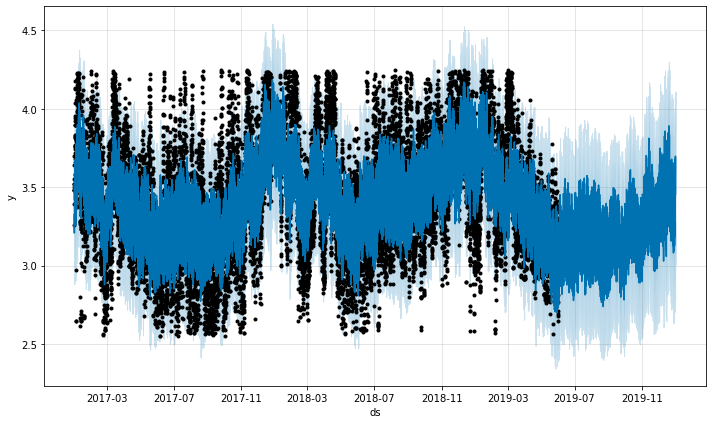

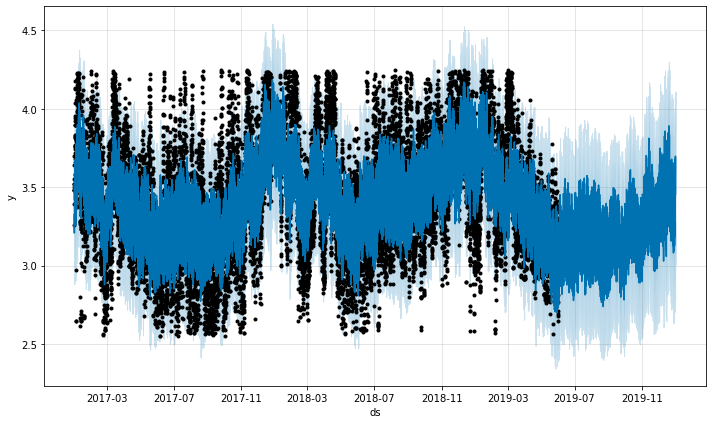

In [18]:
m.plot(fcst)

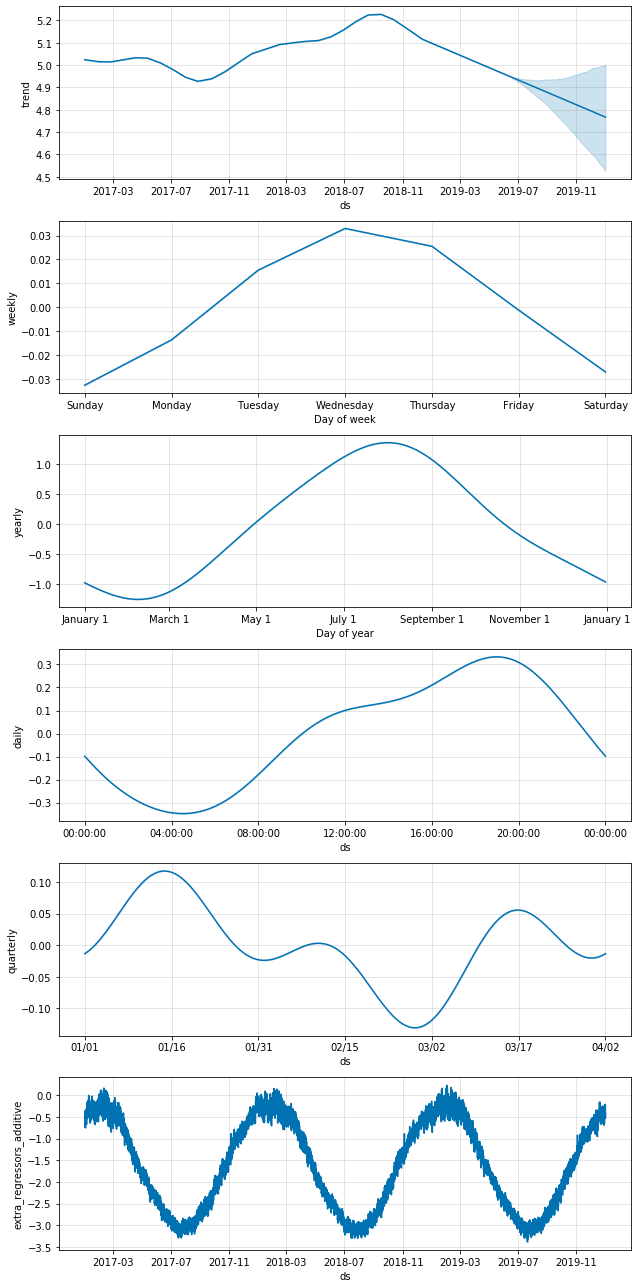

In [19]:
f = m.plot_components(fcst)

In [20]:
print(fcst.shape)
fcst.head(2)

(26279, 64)


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,DEWPOINT_NORM_95,DEWPOINT_NORM_95_lower,DEWPOINT_NORM_95_upper,HOURENDING,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-01-01 01:00:00,5.024360,2.968121,3.664869,5.024360,5.024360,-0.394762,-0.394762,-0.394762,-0.003728,...,-0.032108,-0.032108,-0.032108,-0.974111,-0.974111,-0.974111,0.0,0.0,0.0,3.326183
1,2017-01-01 02:00:00,5.024347,2.927455,3.608623,5.024347,5.024347,-0.385728,-0.385728,-0.385728,-0.007456,...,-0.031720,-0.031720,-0.031720,-0.974610,-0.974610,-0.974610,0.0,0.0,0.0,3.275256


In [21]:
yhat = fcst.loc[21142:,['yhat']].values
ytrue = test['y'].values

In [22]:
from sklearn.metrics import mean_absolute_error
MAE = mean_absolute_error(np.exp(ytrue),np.exp(yhat))

In [23]:
# overall MAE
round(MAE,1)

6.5

In [24]:
# calculate overall MAPE
def MAPE(predict,target):
    return ( abs((target - predict) / target).mean()) * 100

print ('MAPE: ' + str(MAPE(np.exp(ytrue),np.exp(yhat))) )

MAPE: 38.21446479500564


In [25]:
pred = fcst[['ds','yhat','yhat_lower','yhat_upper']]

In [26]:
pred['DALMP'] = np.exp(fcst['yhat'].values)

C:\Users\sunwh\Downloads\Anaconda\download\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [42]:
pred.to_csv("predicted_values.csv",index=False)

### Visualization

In [28]:
fcst = fcst[21142:]

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


''

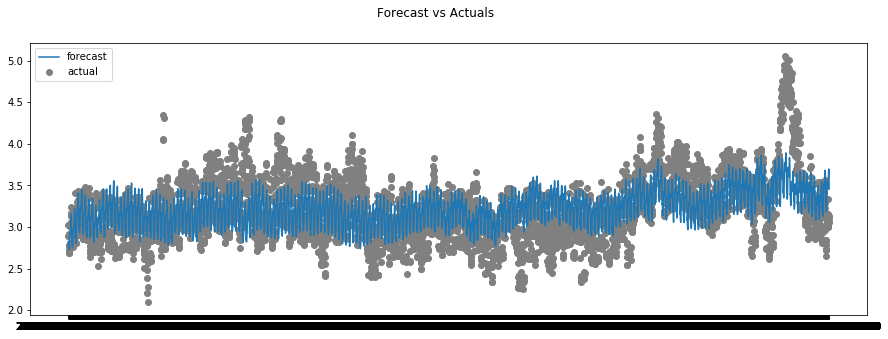

In [29]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(test['ds'], test['y'], color='gray',label='actual')
plt.plot(fcst['yhat'].values,label='forecast')

ax.legend()
plt.legend()
plot = plt.suptitle('Forecast vs Actuals')
;